In [45]:
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import numpy as np

In [137]:
# import tensorflow datasets
data = tf.data.TFRecordDataset('../../../data/external/EuroSAT/eurosat/rgb/2.0.0/eurosat-train.tfrecord-00000-of-00001')

labels = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

In [20]:
# inspect the first record
for raw_record in data.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

features {
  feature {
    key: "filename"
    value {
      bytes_list {
        value: "SeaLake_2401.jpg"
      }
    }
  }
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\377\333\000C\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\377\300\000\021\010\000@\000@\003\001\"\000\002\021\001\003\021\001\377\304\000\027\000\001\001\001\001\000\000\000\000\000\000\000\000\000\000\000\000\001\000\002\n\377\304\000(\020\

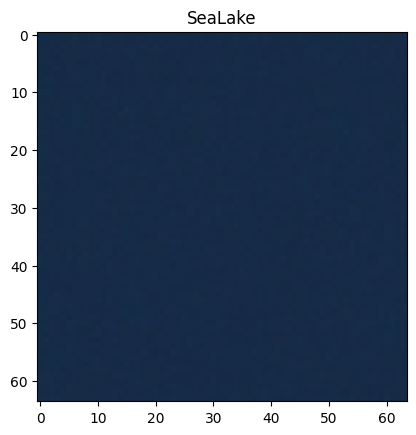

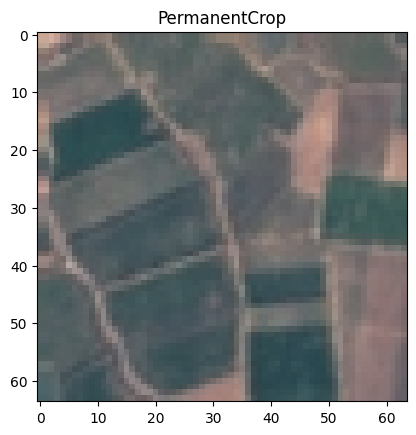

In [134]:
# show first 2 images
for raw_record in data.take(2):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    image = example.features.feature['image'].bytes_list.value[0]
    label = example.features.feature['label'].int64_list.value[0]
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    plt.imshow(image)
    plt.title(labels[label])
    plt.show()

In [21]:
# see length of dataset
print(len(list(data)))

27000


In [22]:
# print size of each of the 10 classes
for label in labels:
    count = 0
    for raw_record in data:
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        if example.features.feature['label'].int64_list.value[0] == labels.index(label):
            count += 1
    print(label, count)

AnnualCrop 3000
Forest 3000
HerbaceousVegetation 3000
Highway 2500
Industrial 2500
Pasture 2000
PermanentCrop 2500
Residential 3000
River 2500
SeaLake 3000


SeaLake
(64, 64, 3)


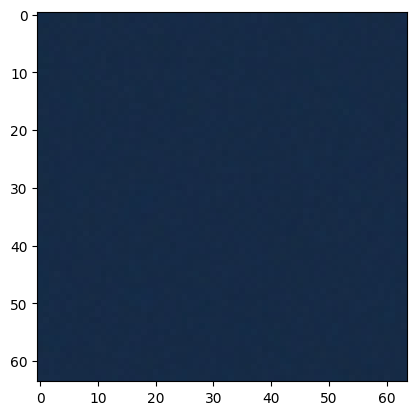

PermanentCrop
(64, 64, 3)


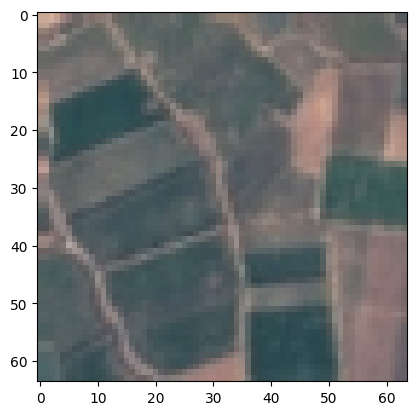

SeaLake
(64, 64, 3)


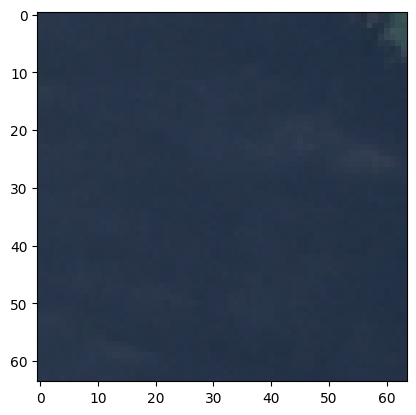

Industrial
(64, 64, 3)


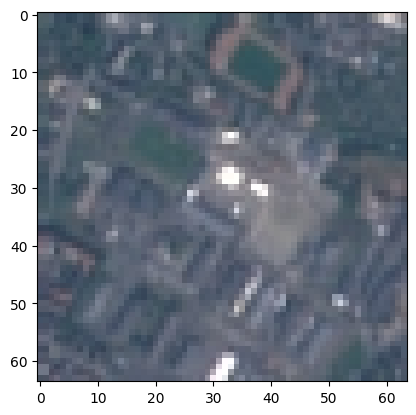

Pasture
(64, 64, 3)


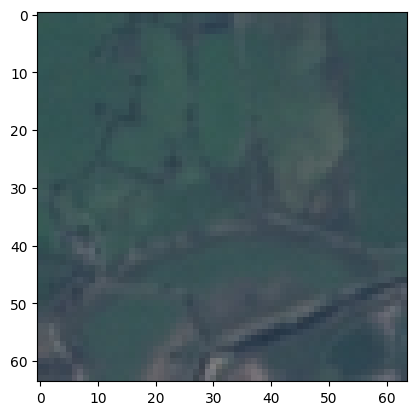

In [135]:
# parse single image from tfrecord
def parse_image(example_proto):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    parsed_features = tf.io.parse_single_example(example_proto, features)
    image = tf.io.decode_jpeg(parsed_features['image'])

    label = tf.cast(parsed_features['label'], tf.int32)
    return image, label

def resize_image(image, label):
    image = tf.image.resize(image, [64, 64])
    return image, label

def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    return image, label

def split_into_batches(dataset, batch_size):
    return dataset.cache().shuffle(27000).batch(batch_size)

def split_into_train_test_validation(dataset, batch_size):
    # Find the length of the dataset
    length_of_dataset = len(list(dataset))

    # Determine the size of each dataset
    train_size = int(0.5 * length_of_dataset)
    validation_set = int(0.3 * length_of_dataset)
    test_size = int(0.2 * length_of_dataset)

    # Split the dataset into train, validation and test sets
    train_dataset = dataset.take(train_size).cache().shuffle(train_size).batch(batch_size)
    validation_dataset = dataset.skip(train_size).take(validation_set).cache().shuffle(validation_set).batch(batch_size)
    test_dataset = dataset.skip(train_size).skip(validation_set).take(test_size).cache().shuffle(test_size).batch(batch_size)
    return train_dataset, validation_dataset, test_dataset


def sample_images(dataset, batch_size, num_batches=500):
    return dataset.take(num_batches*batch_size).cache().batch(batch_size)

parsed_image_dataset = data.map(parse_image)
parsed_image_dataset = parsed_image_dataset.map(resize_image)

for image, label in parsed_image_dataset.take(5):
  image_raw = image.numpy()
  print(labels[label.numpy()])
  print(image_raw.shape)
  plt.imshow(image_raw.astype('uint8'))
  plt.show()
  plt.close()
  
parsed_image_dataset = parsed_image_dataset.map(normalize)
# split into train and test
train_dataset, validation_dataset, test_dataset = split_into_train_test_validation(dataset=parsed_image_dataset, batch_size=50)

  

In [26]:

# build CNN model
def build_model(number_of_conv2d_layers=2, number_of_filters=32, kernel_size=(3, 3), activation='relu', padding='same', pool_size=(2, 2), dropout=0.25, number_of_dense_layers=2, number_of_dense_nodes=128, dense_activation='relu', output_activation='softmax', loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']):
    # augment data
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(1, input_shape=(64, 64, 3)),
        tf.keras.layers.RandomZoom(height_factor=0.5, width_factor=0.5),
    ])

    # create number_of_conv2d_layers:
    conv2d_layers = []
    for i in range(number_of_conv2d_layers):
        conv2d_layers.append(tf.keras.layers.Conv2D(number_of_filters, kernel_size, activation=activation, padding=padding))
        conv2d_layers.append(tf.keras.layers.MaxPooling2D(pool_size))
        conv2d_layers.append(tf.keras.layers.Dropout(dropout))

    # create dense layers in for loop
    dense_layers = []
    for i in range(number_of_dense_layers):
        dense_layers.append(tf.keras.layers.Dense(number_of_dense_nodes, activation=dense_activation))
        dense_layers.append(tf.keras.layers.Dropout(dropout))
    
    model = tf.keras.Sequential([
        data_augmentation,
        tf.keras.Sequential(conv2d_layers),
        tf.keras.layers.Flatten(),
        tf.keras.Sequential(dense_layers),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
    return model

# create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=10, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

# grid search hyperpameters, save best model

# store results
results = []
for number_of_dense_layers in [2, 3, 4]:
    for number_of_dense_nodes in [128, 256, 512]:
        for dropout in [0.1, 0.2, 0.4]:
                model = build_model(number_of_conv2d_layers=number_of_conv2d_layers, number_of_filters=number_of_filters, number_of_dense_layers=number_of_dense_layers, number_of_dense_nodes=number_of_dense_nodes, dropout=dropout)
                history = model.fit(train_dataset, epochs=50, batch_size=50, validation_data=test_dataset, callbacks=[early_stopping])
                results.append((number_of_conv2d_layers, number_of_filters, number_of_dense_layers, number_of_dense_nodes, dropout, history.history['val_accuracy'][-1]))
                model.save(f'../../../models/EuroSAT/{number_of_conv2d_layers}_{number_of_filters}_{number_of_dense_layers}_{number_of_dense_nodes}_{dropout}.h5')



Epoch 1/50
270/270 [==============================] - 54s 179ms/step - loss: 1.8540 - accuracy: 0.2753 - val_loss: 1.5625 - val_accuracy: 0.4544
Epoch 2/50
270/270 [==============================] - 44s 162ms/step - loss: 1.5171 - accuracy: 0.4282 - val_loss: 1.3254 - val_accuracy: 0.5496
Epoch 3/50
270/270 [==============================] - 44s 162ms/step - loss: 1.3533 - accuracy: 0.5070 - val_loss: 1.2451 - val_accuracy: 0.5628
Epoch 4/50
270/270 [==============================] - 43s 159ms/step - loss: 1.2243 - accuracy: 0.5610 - val_loss: 1.1038 - val_accuracy: 0.6087
Epoch 5/50
270/270 [==============================] - 43s 160ms/step - loss: 1.1119 - accuracy: 0.6088 - val_loss: 1.0239 - val_accuracy: 0.6369
Epoch 6/50
270/270 [==============================] - 44s 161ms/step - loss: 1.0518 - accuracy: 0.6301 - val_loss: 0.9780 - val_accuracy: 0.6589
Epoch 7/50
270/270 [==============================] - 43s 161ms/step - loss: 1.0031 - accuracy: 0.6396 - val_loss: 0.9835 - val_ac

ValueError: 5 columns passed, passed data had 6 columns

In [64]:
# store results in dataframe
results_df = pd.DataFrame(results, columns=['number_of_conv2d_layers', 'number_of_filters', 'number_of_dense_layers', 'number_of_dense_nodes', 'dropout', 'val_accuracy'])
results_df.sort_values(by='val_accuracy', ascending=False, inplace=True)
results_df.to_csv('../../../data/processed/EuroSAT/results.csv', index=False)
results_df

,number_of_conv2d_layers,number_of_filters,number_of_dense_layers,number_of_dense_nodes,dropout,val_accuracy
6,2,32,2,512,0.1,0.860741
12,2,32,3,256,0.1,0.848333
21,2,32,4,256,0.1,0.845926
18,2,32,4,128,0.1,0.838148
15,2,32,3,512,0.1,0.831111
9,2,32,3,128,0.1,0.827222
0,2,32,2,128,0.1,0.808519
24,2,32,4,512,0.1,0.806667
3,2,32,2,256,0.1,0.803889
7,2,32,2,512,0.2,0.791481


/var/folders/nc/v4p72y255nn_y662tn1s3yv00000gp/T/ipykernel_38326/3638655007.py:15: MatplotlibDeprecationWarning:

The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.



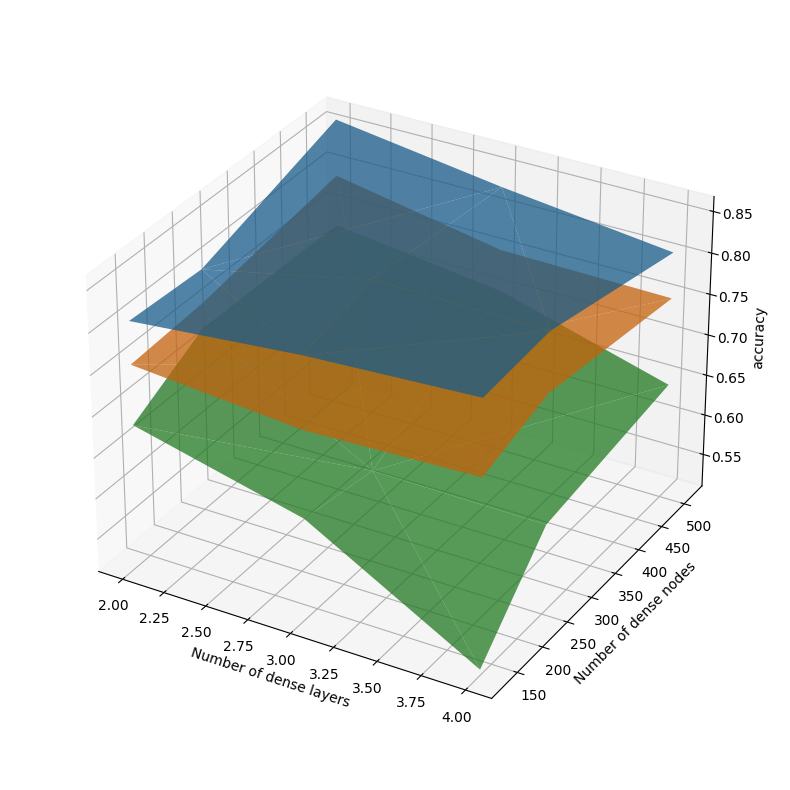

In [136]:
# plot multiple surface plot of results using matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for name, group in results_df.groupby("dropout"):
    ax.plot_trisurf(group['number_of_dense_layers'], group['number_of_dense_nodes'], group['val_accuracy'], linewidth=0.5, alpha=0.75, label=name)

ax.set_xlabel('Number of dense layers')
ax.set_ylabel('Number of dense nodes')
ax.set_zlabel('accuracy')

# zoom out slightly so that all axis labels are visible
ax.dist = 11



plt.show()


In [33]:
best_model = tf.keras.models.load_model(f'../../../models/EuroSAT/2_32_2_512_0.1.h5')
best_model

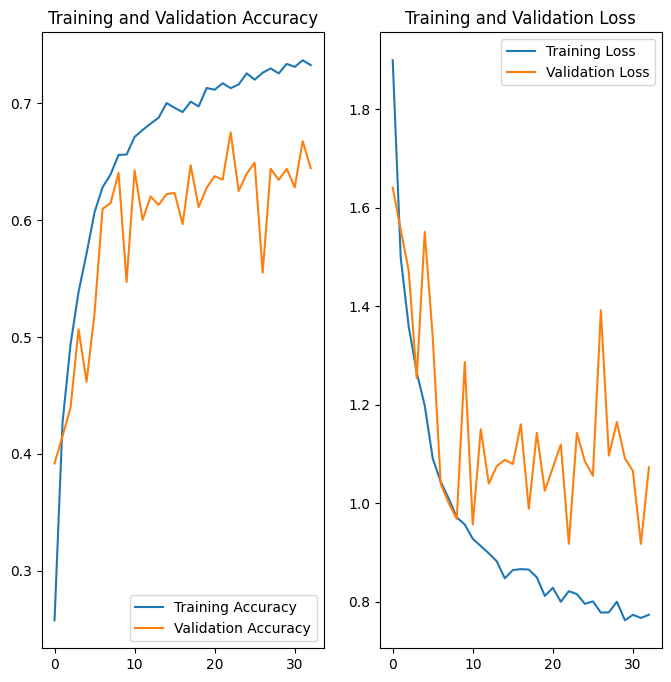

In [30]:
# plot accuracy and loss curves
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)


2/2 [==============================] - 0s 15ms/step


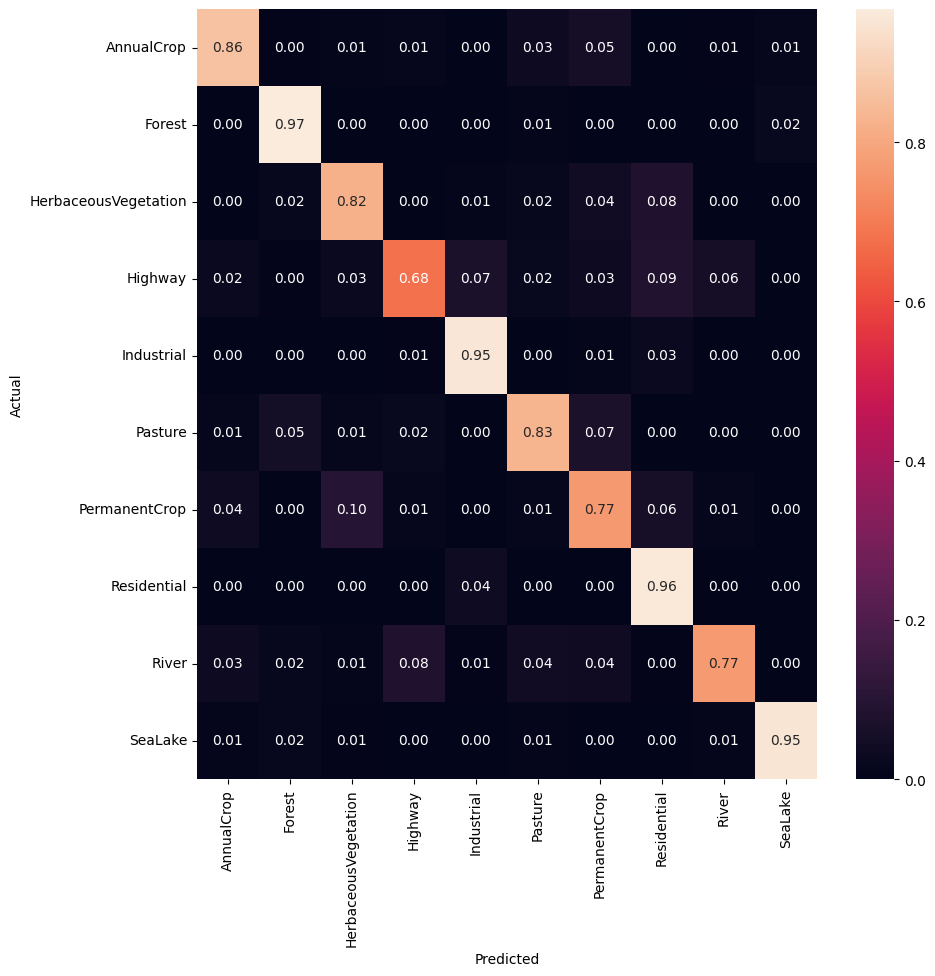

In [138]:
# evaluate in a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

y_true = []
y_pred = []
images = []
for image, label in test_dataset:
    y_true.append(label)
    y_pred.append(best_model.predict(image))
    images.append(image)

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
image_list = np.concatenate(images)

y_pred_max = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_max)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

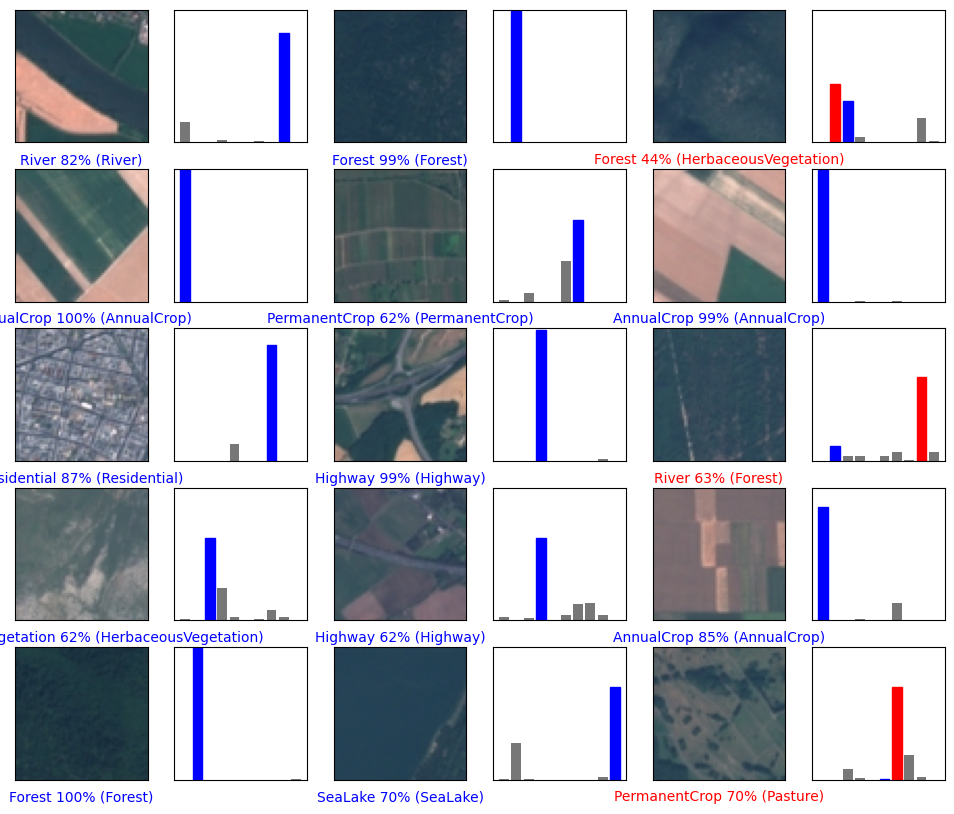

In [133]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img[...], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(labels[predicted_label],
                                100*np.max(predictions_array),
                                labels[true_label]),
                                color=color)
  # change xlabel size
  plt.rcParams['xtick.labelsize'] = 10

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, y_pred, y_true, image_list)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, y_pred, y_true)
plt.savefig('../../../reports/figures/EuroSAT/satellite_items.png')
